In [18]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.abspath('../..'))
from g4l.estimators import BIC
from g4l.estimators import SMC
import g4l.display
from g4l.estimators import Prune
from g4l.models import ContextTree
from g4l.data import Sample
from g4l.bootstrap.resampling import BlockResampling
from g4l.bootstrap import Bootstrap


#results_folder = os.path.abspath('../simulation_study/results')
max_depth = 4

In [97]:
samples_folder = "../../examples/linguistic_case_study"
X_bp = Sample('%s/folha.txt' % samples_folder, [0, 1, 2, 3, 4])
X_ep = Sample('%s/publico.txt' % samples_folder, [0, 1, 2, 3, 4])

cache_folder = "../../examples/linguistic_case_study/cache/smc2"
resamples_folder = '%s/resamples' % cache_folder
resamples_file = "%s/resamples.txt" % resamples_folder

In [98]:
def run_smc(X, instance_name='bp'):
    L_path = "%s/L_%s.npy" % (resamples_folder, instance_name)
    n_sizes = (int(len(X.data) * 0.3), int(len(X.data) * 0.9)) # 29337, 88011
    smc = SMC(max_depth,
              penalty_interval=(0.1, 800),
              epsilon=0.01,
              cache_dir=cache_folder)
    smc.fit(X)
    champion_trees = smc.context_trees

    bootstrap = Bootstrap(champion_trees, resamples_file, n_sizes)
    # try loading from cache
    try:
        L = np.load(L_path)
    except:
        resample_fctry = BlockResampling(X_bp, resamples_file,
                                         n_sizes,
                                         RENEWAL_POINT)
        resample_fctry.generate(NUM_RESAMPLES, num_cores=NUM_CORES)

        L = bootstrap.calculate_likelihoods(resamples_folder, num_cores=NUM_CORES)
        np.save(L_path, L)

    diffs = bootstrap.calculate_diffs(L)
    opt_idx = bootstrap.find_optimal_tree(diffs, alpha=0.01)
    return champion_trees, opt_idx

def model_df(champion_trees, opt_idx):
    df = pd.DataFrame(columns=['idx', 'num_contexts', 'log_likelihood', 'tree', 'opt'])
    df['opt'] = 0
    for i, tree in enumerate(champion_trees):
        opt = i == opt_idx
        df.loc[len(df)] = [i, tree.num_contexts(), tree.log_likelihood(), tree.to_str(reverse=True), opt]
    opt_tree = champion_trees_bp[opt_idx]
    return df.sort_values('idx', ascending=False)

### Estimating models for Brazilian Portuguese (BP) 

In [99]:
champion_trees_bp, opt_idx_bp = run_smc(X_bp, instance_name='bp')
opt_tree_bp = champion_trees_bp[opt_idx_bp]
df_bp = model_df(champion_trees_bp, opt_idx_bp)
print("Selected tree BP:", champion_trees_bp[opt_idx_bp].to_str(reverse=True))
df_bp.head(8)

Loaded from cache
Selected tree BP: 0000 2000 100 200 300 0010 2010 210 20 30 001 201 21 002 0102 2102 302 012 212 32 42 3 4


,idx,num_contexts,log_likelihood,tree,opt
18,18,5,-104343.127363,0 1 2 3 4,0
17,17,8,-81640.985369,00 10 20 30 1 2 3 4,0
16,16,11,-77496.690829,000 100 200 300 10 20 30 1 2 3 4,0
15,15,13,-77355.639636,000 100 200 300 10 20 30 001 201 21 2 3 4,0
14,14,14,-77308.001068,000 100 200 300 010 210 20 30 001 201 21 2 3 4,0
13,13,15,-77284.748925,0000 2000 100 200 300 010 210 20 30 001 201 21...,0
12,12,16,-77250.049699,0000 2000 100 200 300 0010 2010 210 20 30 001 ...,0
11,11,23,-77190.062753,0000 2000 100 200 300 0010 2010 210 20 30 001 ...,1


### Estimating models for European Portuguese (EP) 

In [100]:
champion_trees_ep, opt_idx_ep = run_smc(X_ep, instance_name='ep')
opt_tree_ep = champion_trees_ep[opt_idx_ep]
df_ep = model_df(champion_trees_ep, opt_idx_ep)
print("Selected tree EP:", opt_tree_ep.to_str(reverse=True))
df_ep.head(10)

Loaded from cache
Selected tree EP: 0000 2000 100 200 300 0010 2010 210 20 30 001 201 21 02 012 212 32 42 3 4


,idx,num_contexts,log_likelihood,tree,opt
18,18,5,-112142.288240,0 1 2 3 4,0
17,17,8,-87559.415391,00 10 20 30 1 2 3 4,0
16,16,11,-83473.606457,000 100 200 300 10 20 30 1 2 3 4,0
15,15,13,-83316.343784,000 100 200 300 10 20 30 001 201 21 2 3 4,0
14,14,14,-83268.852081,000 100 200 300 010 210 20 30 001 201 21 2 3 4,0
13,13,15,-83256.302808,0000 2000 100 200 300 010 210 20 30 001 201 21...,0
12,12,18,-83225.661353,0000 2000 100 200 300 010 210 20 30 001 201 21...,0
11,11,19,-83210.613754,0000 2000 100 200 300 0010 2010 210 20 30 001 ...,0
10,10,20,-83203.627618,0000 2000 100 200 300 0010 2010 210 20 30 001 ...,1
9,9,23,-83166.590368,0000 2000 100 200 300 0010 2010 0210 1210 3210...,0


In [101]:
#import g4l.display
#g4l.display.draw_tree(opt_tree_ep, size='100,300')
print(opt_tree_bp.to_str())
print(opt_tree_ep.to_str())

0000 001 0010 002 0102 012 100 20 200 2000 201 2010 21 210 2102 212 3 30 300 302 32 4 42
0000 001 0010 012 02 100 20 200 2000 201 2010 21 210 212 3 30 300 32 4 42


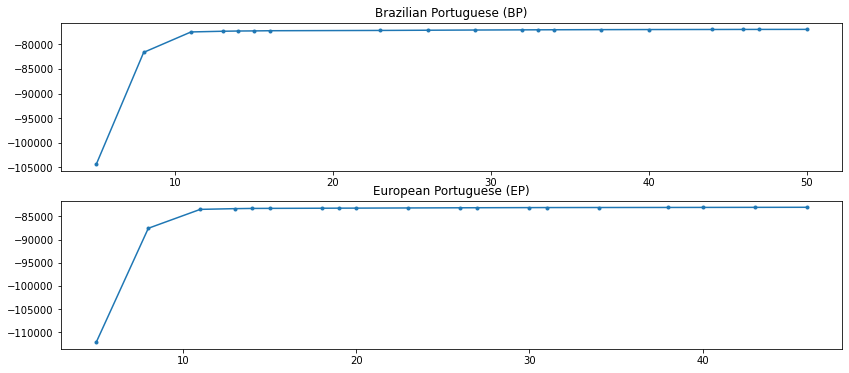

In [102]:
plt.figure(figsize=(14, 6))
txt = ['Brazilian Portuguese (BP)', 'European Portuguese (EP)']
for i, el in enumerate([champion_trees_bp, champion_trees_ep]):
    plt.subplot(2, 1, i+1)
    num_contexts = [t.num_contexts() for t in el]
    likelihoods = [t.log_likelihood() for t in el]
    plt.plot(num_contexts, likelihoods, marker='.')
    plt.title(txt[i])
plt.show()

In [106]:
def transition_table_df(tree):
    dd = tree.transition_probs.set_index('idx')
    df2 = pd.DataFrame(columns=['w', 'nodesort', 'p(0|w)', 'p(1|w)', 'p(2|w)', 'p(3|w)'])
    for i, row in tree.tree().iterrows():
        ps = [dd[dd.next_symbol == str(j)].loc[row.node_idx].prob.round(2) for j in [0, 1, 2, 3]]
        df2.loc[len(df2)] = [row.node, row.node[::-1], *ps]
    df2.sort_values('nodesort', inplace=True)
    df2.set_index('nodesort', inplace=True)
    df2.reset_index(inplace=True, drop=True)
    return df2

transition_table_df(opt_tree_bp)

,w,p(0|w),p(1|w),p(2|w),p(3|w)
0,0000,0.20,0.80,0.00,0.00
1,2000,0.32,0.68,0.00,0.00
2,100,0.00,0.00,0.67,0.21
3,200,0.40,0.60,0.00,0.00
4,300,0.00,0.00,0.67,0.22
5,0010,0.03,0.00,0.67,0.20
6,2010,0.07,0.00,0.66,0.19
7,210,0.08,0.00,0.63,0.22
8,20,0.45,0.55,0.00,0.00
9,30,0.07,0.00,0.64,0.25


In [104]:
transition_table_df(opt_tree_ep)

,w,p(0|w),p(1|w),p(2|w),p(3|w)
0,0000,0.21,0.79,0.00,0.00
1,2000,0.30,0.70,0.00,0.00
2,100,0.00,0.00,0.67,0.25
3,200,0.36,0.64,0.00,0.00
4,300,0.00,0.00,0.70,0.20
5,0010,0.04,0.00,0.68,0.19
6,2010,0.06,0.00,0.67,0.19
7,210,0.08,0.00,0.63,0.21
8,20,0.45,0.55,0.00,0.00
9,30,0.05,0.00,0.63,0.27
